# Analysis of the experimental LSTM and EA-LSTM model results
This notebooks reproduces the results related to the abstract [The Impact of Land Cover Data on Rainfall-Runoff Prediction Using an Entity-Aware-LSTM](https://meetingorganizer.copernicus.org/EGU21/EGU21-1136.html) presented as a vPICO
presentation at the EGU General Assembly 2021 in the session _HS3.4 - 'Deep learning in hydrological science'_.

```
Drost, S., Netzel, F., Wytzisk-Ahrens, A., and Mudersbach, C.: The Impact of Land Cover Data on Rainfall-Runoff
Prediction Using an Entity-Aware-LSTM, EGU General Assembly 2021, online, 19–30 Apr 2021, EGU21-1136,
https://doi.org/10.5194/egusphere-egu21-1136, 2021.
```

## Setup

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from scripts import metricsutils

os.environ['KMP_DUPLICATE_LIB_OK']='True'

run_dir = "./runs/"
experiment_names = ["lstm-camelsgb-wv", "ealstm-camelsgb-wv", "lstm-wv-l1o", "ealstm-wv-l1o"]
basin_path = "./data/wv/main_basin.geojson"
subbasin_path = "./data/wv/subbasins.geojson"
gauges_path = "./data/wv/gauges.geojson"

## Area of study

### Load geospatial data

In [2]:
# Read geospatial data
basin = gpd.read_file(basin_path)
subbasins = gpd.read_file(subbasin_path)
gauges = gpd.read_file(gauges_path)

### The Wupper region

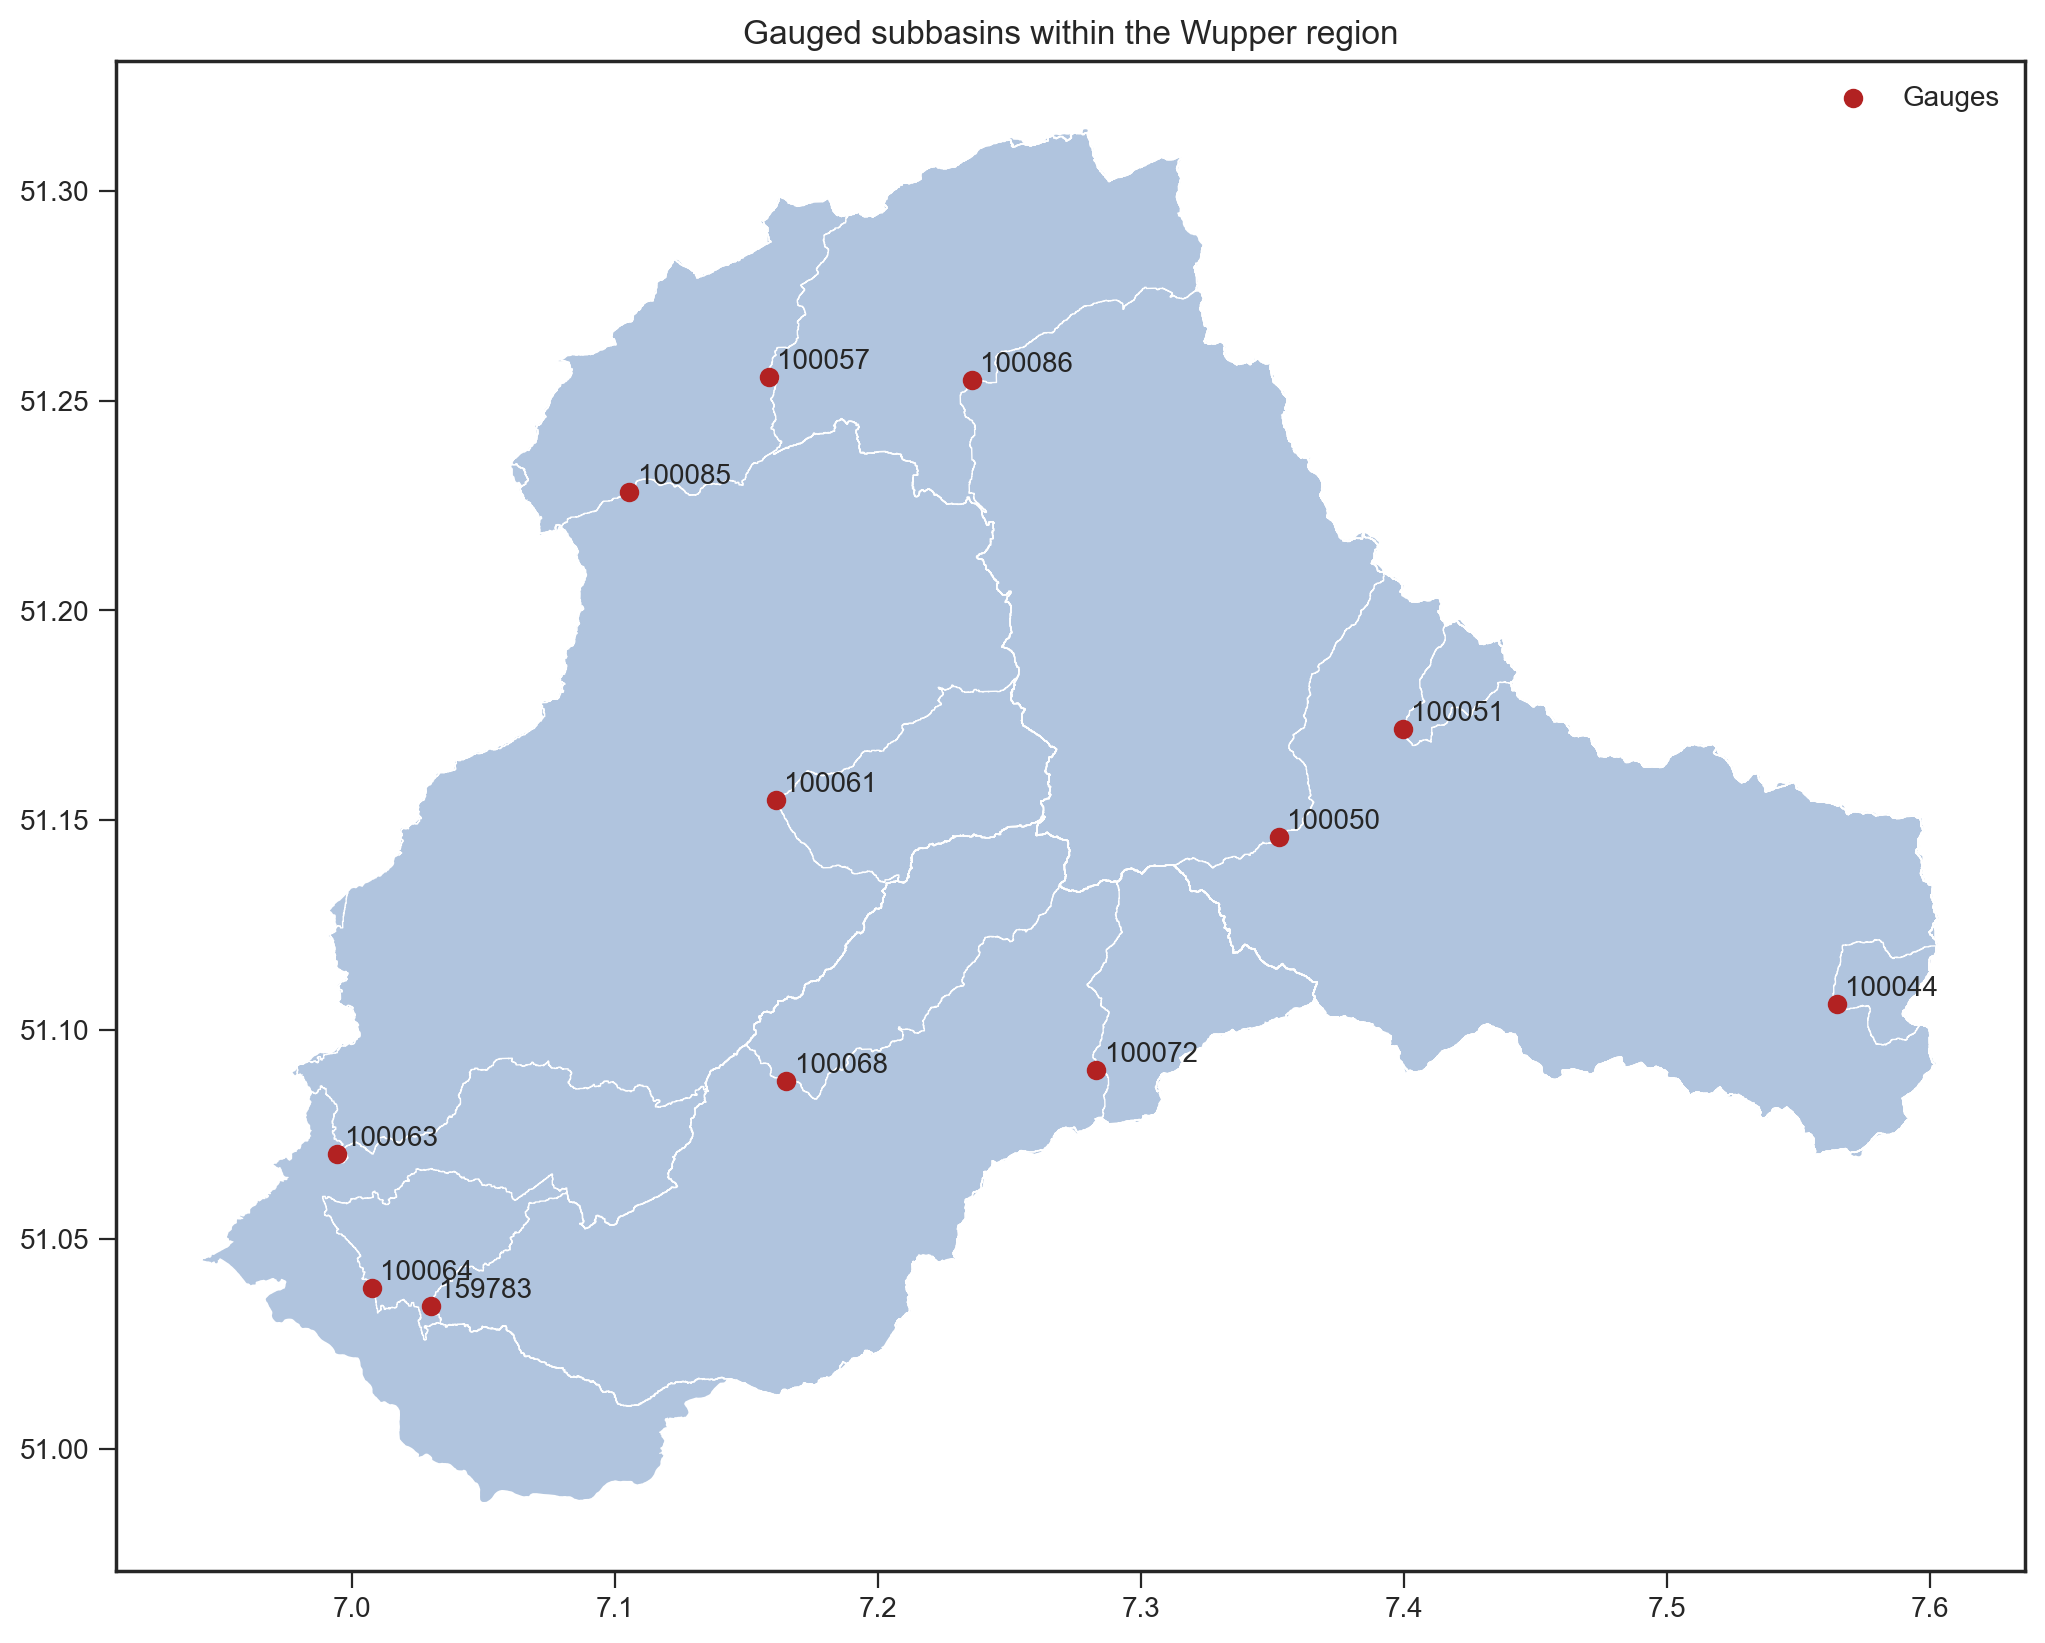

In [3]:
plt.style.use('seaborn-ticks')
fig, ax = plt.subplots(figsize=(16, 10), dpi = 200)
ax.set_aspect('equal')
basin.plot(ax=ax, label="Wupper region", color='lightsteelblue')
subbasins.plot(ax=ax, color="none", linewidth=0.5, edgecolor='white', label="Subbasins")
gauges.plot(ax=ax, marker='o', color='firebrick', label="Gauges")
ax.set_title("Gauged subbasins within the Wupper region")
ax.legend()

for x, y, label in zip(gauges.geometry.x, gauges.geometry.y, gauges.id):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points", fontsize=10)

 ## Analyse evalutation metrics

### Load overall metrcics

In [4]:
# Read overall metrics
results = pd.DataFrame()
for exp in experiment_names:
    exp_result = metricsutils.gather_nse_metrics(run_dir, exp)
    results = results.append(exp_result, ignore_index=True)

### Subbasin specific NSE values

Text(0.5, 0.98, 'Subbasin specific NSE values')

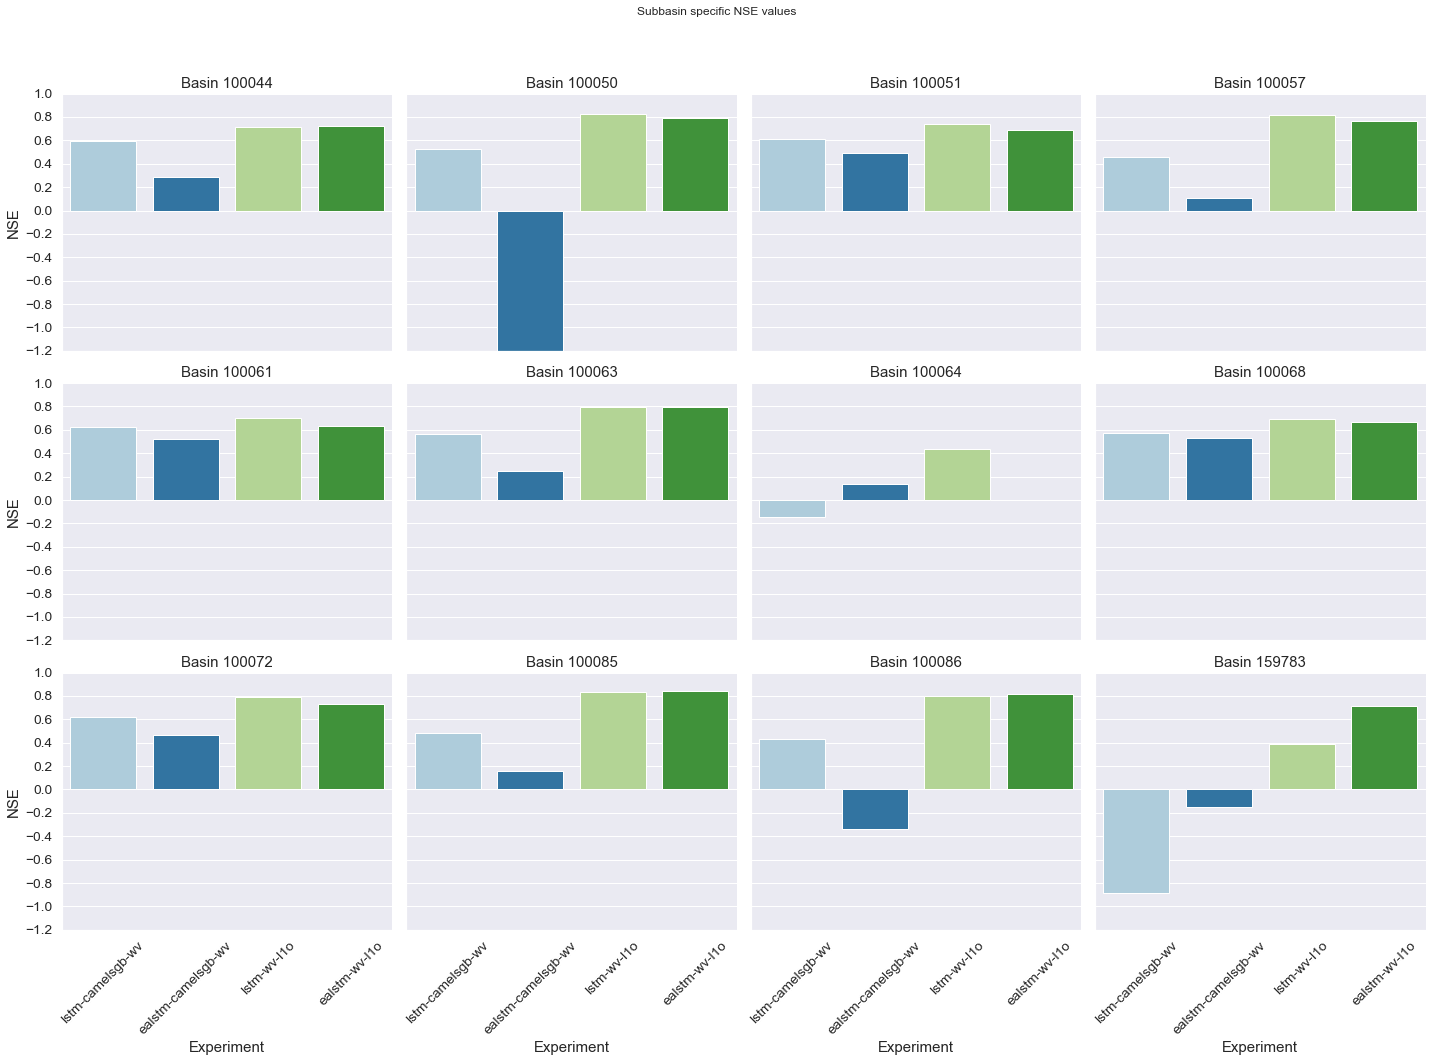

In [5]:
plt.style.use('ggplot')
sns.set_theme(font_scale=1.25)
%matplotlib inline

g = sns.catplot(x="exp_name", y="nse", col="basin_id", kind="bar", col_wrap=4, palette="Paired", data=results)
g.set(ylim=(-1.2, 1), yticks=np.arange(-1.2, 1.2, 0.2))
g.set_axis_labels("Experiment", "NSE")
g.set_xticklabels(rotation=45)
g.set_titles("Basin {col_name}")
plt.tight_layout()
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Subbasin specific NSE values")

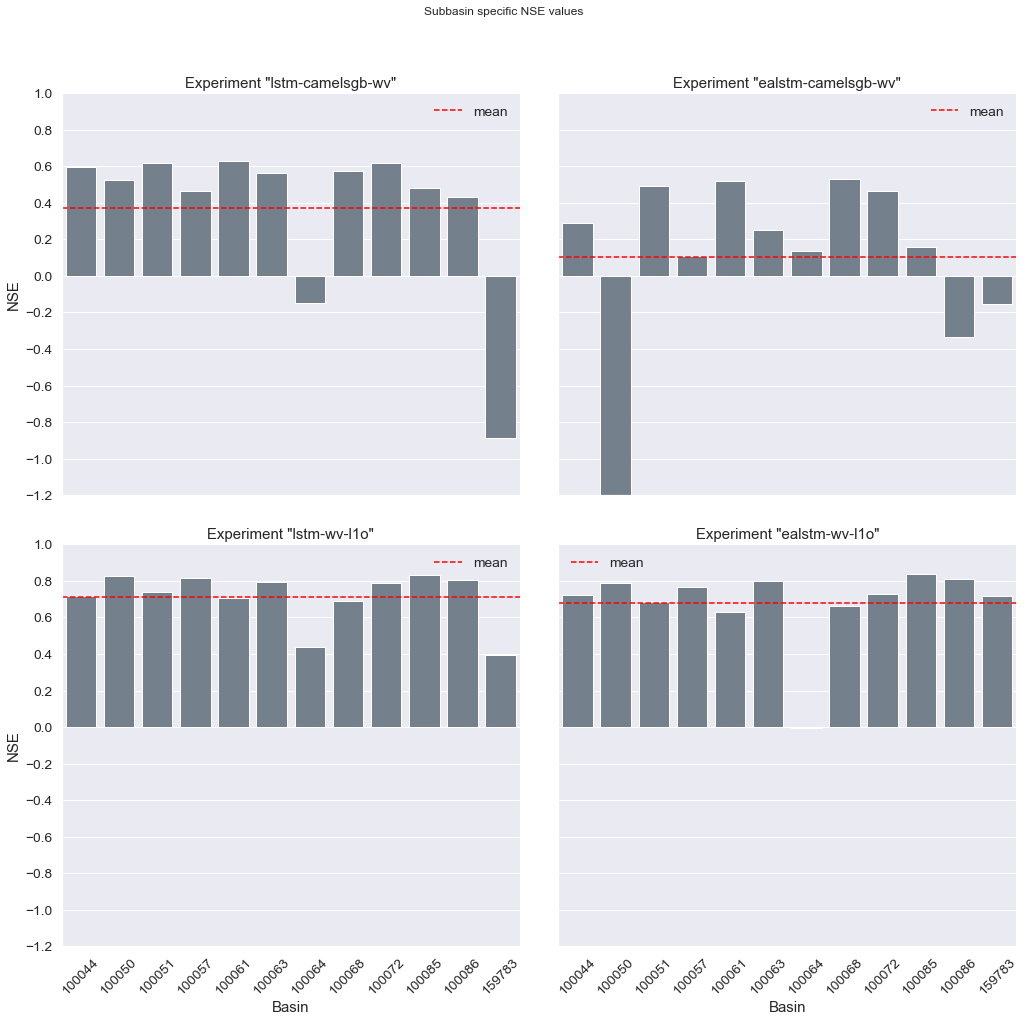

In [6]:
g = sns.catplot(x="basin_id", y="nse", col="exp_name", kind="bar", col_wrap=2, color="slategrey", data=results)
g.set(ylim=(-1.2, 1), yticks=np.arange(-1.2, 1.2, 0.2))
g.set_axis_labels("Basin", "NSE")
g.set_xticklabels(rotation=45)
plt.tight_layout()
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Subbasin specific NSE values")
g.fig.set_size_inches(15,15)

means = results.groupby('exp_name').mean()
for ax in g.axes:
    exp = ax.get_title().split("=")[1].lstrip()
    ax.set_title("Experiment " + '"' + exp + '"')
    nse = means.loc[exp, "nse"]
    ax.axhline(nse, ls='--', color="red", label="mean")
    ax.legend()

### Summary of NSE values

Text(0.5, 0.98, 'Mean NSE over all subbasins')

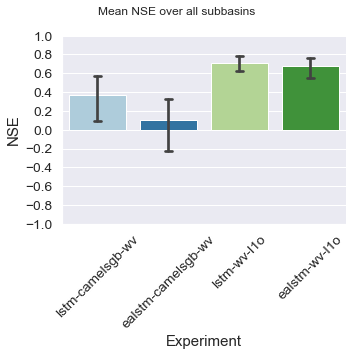

In [7]:
g = sns.catplot(x="exp_name", y="nse", kind="bar", palette="Paired", data=results, capsize=.1)
g.set(ylim=(-1.0, 1), yticks=np.arange(-1.0, 1.2, 0.2))
g.set_axis_labels("Experiment", "NSE")
g.set_xticklabels(rotation=45)
plt.tight_layout()
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Mean NSE over all subbasins")

Text(0.5, 0.98, 'Distribution of NSE values over all subbasins')

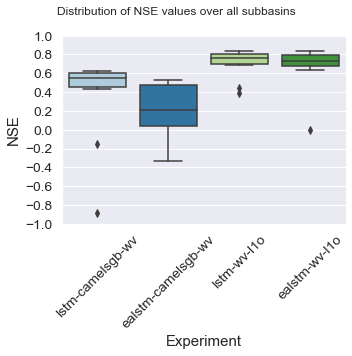

In [8]:
g = sns.catplot(x="exp_name", y="nse", kind="box", data=results, palette="Paired")
g.set(ylim=(-1.0, 1), yticks=np.arange(-1.0, 1.2, 0.2))
g.set_axis_labels("Experiment", "NSE")
g.set_xticklabels(rotation=45)
plt.tight_layout()
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Distribution of NSE values over all subbasins")

### Generate annual NSE metrics 

In [9]:
# Yearly NSE analysis
yearly_results = pd.DataFrame()
for exp in experiment_names:
    exp_result = metricsutils.calculate_yearly_nse(run_dir, exp, 1990, 2020)
    yearly_results = yearly_results.append(exp_result, ignore_index=True)
yearly_results.replace([np.inf, -np.inf], np.nan, inplace=True)

### Temporal NSE curve

Text(0.5, 0.98, 'Yearly NSE for different subbasins')

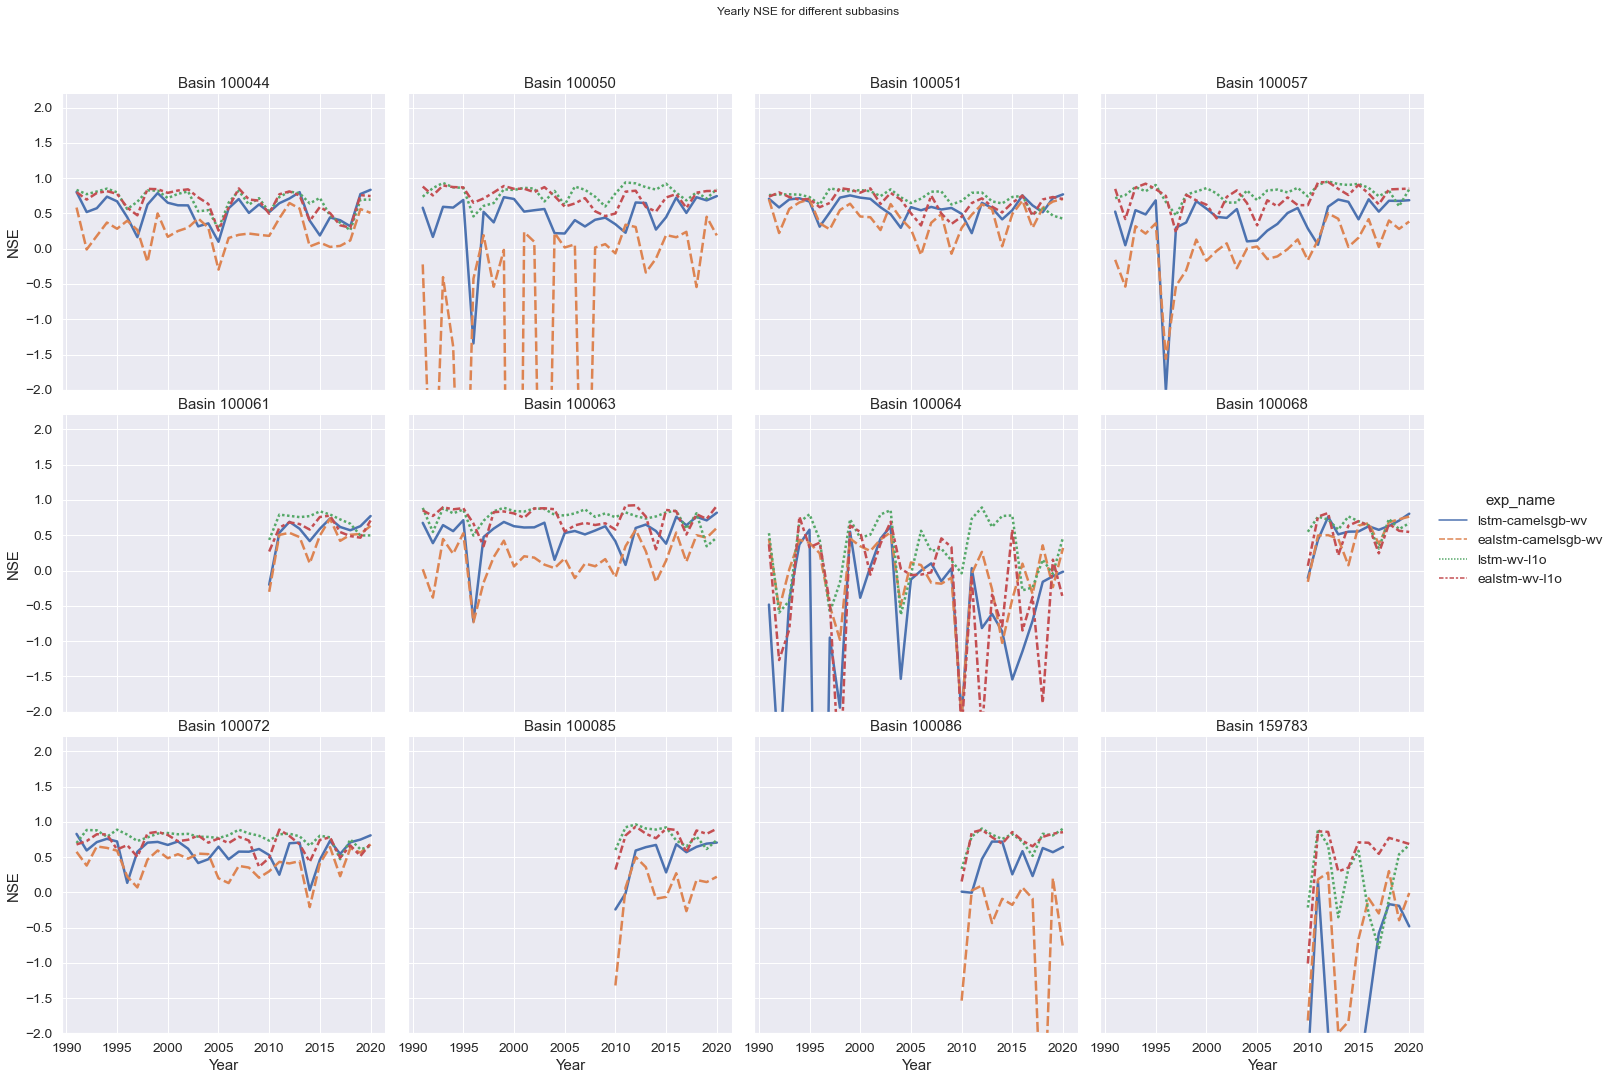

In [10]:
g = sns.relplot(x="year", y="nse", hue="exp_name", style="exp_name", col="basin_id", col_wrap=4,
                linewidth=2.5, kind="line", data=yearly_results)
g.set(ylim=(-2, 2.2), yticks=np.arange(-2, 2.5, 0.5))
g.set_axis_labels("Year", "NSE")
g.set_titles("Basin {col_name}")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Yearly NSE for different subbasins")

### Temporal trends

Text(0.5, 0.98, 'Trend of mean NSE over all subbasins for different experiments')

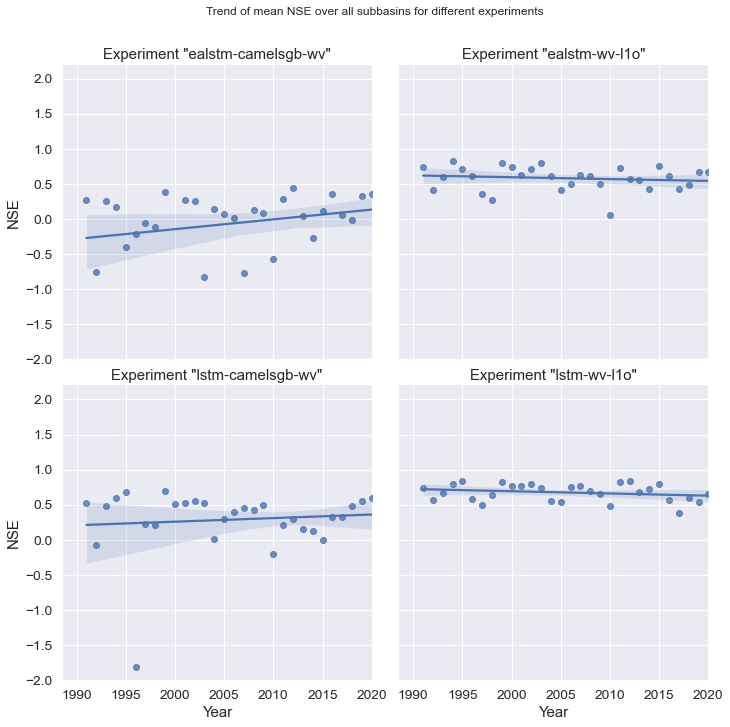

In [11]:
means = yearly_results.groupby(["exp_name", "year"]).mean()
means = means.reset_index(level=["exp_name", "year"])

g = sns.lmplot(x="year", y="nse", col="exp_name", col_wrap=2, data=means)
g.set(ylim=(-2, 2.2), yticks=np.arange(-2, 2.5, 0.5))
g.set_axis_labels("Year", "NSE")
g.set_titles('Experiment "{col_name}"')
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Trend of mean NSE over all subbasins for different experiments")